In [1]:
from __future__ import print_function

import os
import cv2
import copy
import json
import numpy as np
from tqdm import tqdm


from keras.layers import *
from keras.models import Model
from bert4keras.layers import Loss
from bert4keras.optimizers import Adam
from bert4keras.backend import keras, K
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.snippets import sequence_padding, is_string
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder

from caption_eval.custom_caption_eval import calculate_metrics

Using TensorFlow backend.


In [2]:
# bert配置
config_path = 'bert-model/uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'bert-model/uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'bert-model/uncased_L-12_H-768_A-12/vocab.txt'

# 加载并精简词表，建立分词器
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

# 模型配置
maxlen = 64
batch_size = 16

In [5]:
def read_data(folder):
    """读取并整理COCO的数据,包括caption, object, attributes 和 relationships , 同时提取目标特征.
    单个数据如下:
    [
     {'image_features': [2048]},
     {'key_words': str, 'caption': str},
     {'key_words': str, 'caption': str},
     ...
    ]
    
    返回数据格式:
    -valid:
    [{'image_id':str,
      'features': [2048],
      'caption': [str, str, str, str, str],
      'objects_key_words': [str, str, str, str, str]},
    ...  
    ]
    """
    print('-Read data ...')
    res = []
    
    files = os.listdir(folder)
            
    # 读取image features 和 关键字
    for _, file in tqdm(enumerate(files)):
        file_path = folder + file
        data = np.load(file_path, allow_pickle=True)
        
        image = {}
        image_id = file.replace('npy', 'jpg')
        image['image_id'] = image_id
        image['regions']  = []

        for region in data:
            region['region_feature'] = np.array(region['region_feature'])
            image['regions'].append(region)
            
        res.append(image)
    
    return res 
    
valid_data = read_data('./data/VisualGenome/valid2016/')
print('Valid data: ', len(valid_data))

7it [00:00, 68.56it/s]

-Read data ...


21321it [03:34, 99.20it/s] 

Valid data:  21321


In [8]:
class CrossEntropy(Loss):
    """交叉熵作为loss，并mask掉padding部分
    """
    def compute_loss(self, inputs, mask=None):
        y_true, y_mask, y_pred = inputs
        y_true = y_true[:, 1:]  # 目标token_ids
        y_mask = y_mask[:, 1:]  # segment_ids，刚好指示了要预测的部分
        y_pred = y_pred[:, :-1]  # 预测序列，错开一位
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss
    
# 条件全连接层
x_in = Input(shape=(2048,), name='image_features')
    
# Bert模型
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精简原字表
    layer_norm_cond=x_in,
    layer_norm_cond_hidden_size=512,
    layer_norm_cond_hidden_act='swish',
    additional_input_layers=x_in,
)

output = CrossEntropy(2)(model.inputs[0:2] + model.outputs)

model = Model(model.inputs, output)
model.compile(optimizer=Adam(1e-5))
model.summary()


class AutoCaption(AutoRegressiveDecoder):
    """img2seq解码器
    """
    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        token_ids, segment_ids, image = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        return model.predict([token_ids, segment_ids, image])[:, -1]

    def generate(self, inputs, features, topk=1):
        token_ids, segment_ids = tokenizer.encode(inputs, max_length=maxlen)
        output_ids = self.beam_search([token_ids, segment_ids, features], topk)  # 基于beam search
        return tokenizer.decode(output_ids)


autocaption = AutoCaption(
    start_id=None,
    end_id=tokenizer._token_end_id,
    maxlen=maxlen
)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     multiple             22417920    Input-Token[0][0]                
                                                                 MLM-Norm[0][0]                   
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]        

/home/mist/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output cross_entropy_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cross_entropy_2.
  'be expecting any data to be passed to {0}.'.format(name))


In [13]:
def caption_eval(epoch):
    just_show()
        
    datasetGTS = {}
    datasetRES = {}
        
    GTS_annotations = []
    RES_annotations = []
    
    samples = [valid_data[i] for i in np.random.choice(len(valid_data), 50, replace=False)]
    
    imgId = 0
    for _, sample in tqdm(enumerate(samples), desc='Reading data'):
        for region in sample['regions']:
            res = {}
            res[u'image_id'] = imgId
            res[u'caption'] = autocaption.generate(region['keywords'], region['region_feature'])
            RES_annotations.append(res)
            
            gts = {}
            gts[u'image_id'] = imgId
            gts[u'caption'] = region['caption']
            GTS_annotations.append(gts)
            
            imgId += 1
            
    imgIds = range(imgId)
    datasetGTS['annotations'] = GTS_annotations
    datasetRES['annotations'] = RES_annotations
    
    print(u'-Calculating scores ...')
    scores = calculate_metrics(imgIds, datasetGTS, datasetRES)
    print(scores)
    
    scores['epoch'] = epoch
    
    save_path = 'models/VisualGenome/conditional_kw/'
    
    with open(save_path + 'caption_eval.txt', "a") as f:
        f.write(str(scores) + '\n')

In [14]:
for epoch in range(10):
    model.load_weights('models/VisualGenome/conditional_kw/model_{}.weights'.format(epoch))
    caption_eval(epoch)

Reading data: 0it [00:00, ?it/s]

image_id: 2381518.jpg
key_words: ski snow 
predict: skis in the snow
references: skis on the snow

image_id: 2363550.jpg
key_words: wallet table 
predict: wallet on the table
references: the wallet is on the table



Reading data: 50it [02:31,  3.02s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8093, 'reflen': 9037, 'guess': [8093, 6378, 4663, 2950], 'correct': [4781, 1927, 882, 352]}
ratio: 0.8955405554939807
Bleu_1: 0.526
Bleu_2: 0.376
Bleu_3: 0.288
Bleu_4: 0.224
-computing METEOR score...
METEOR: 0.270
-computing Rouge score...
ROUGE_L: 0.536
-computing CIDEr score...
CIDEr: 2.769
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.586
-computing WMD score...
WMD: 0.356
{'Bleu_1': 0.5257161902017246, 'Bleu_2': 0.37596321104005836, 'Bleu_3': 0.287615314009407, 'Bleu_4': 0.22419437071319098, 'METEOR': 0.2698727705716793, 'ROUGE_L': 0.5361910152445806, 'CIDEr': 2.7694324030333917, 'SPICE': 0.5864819990124397, 'WMD': 0.35611768722814935}
image_id: 1159480.jpg
key_words: kite air 
predict: kite in the air
references: a kite in the air

image_id: 2392323.jpg
key_words: towel mirror 
pred

Reading data: 50it [02:28,  2.97s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 7738, 'reflen': 8907, 'guess': [7738, 6063, 4388, 2716], 'correct': [4775, 1969, 903, 350]}
ratio: 0.8687549118669733
Bleu_1: 0.531
Bleu_2: 0.385
Bleu_3: 0.297
Bleu_4: 0.232
-computing METEOR score...
METEOR: 0.276
-computing Rouge score...
ROUGE_L: 0.554
-computing CIDEr score...
CIDEr: 2.891
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.597
-computing WMD score...
WMD: 0.367
{'Bleu_1': 0.5305601674146146, 'Bleu_2': 0.38489422085335034, 'Bleu_3': 0.2970511930567164, 'Bleu_4': 0.23214297360876945, 'METEOR': 0.27630597405408586, 'ROUGE_L': 0.5543615301142107, 'CIDEr': 2.8910210797398275, 'SPICE': 0.597439128036143, 'WMD': 0.3672736276161866}
image_id: 2390077.jpg
key_words: butter cake 
predict: butter on the cake
references: white frosting on top of a piece of cake

image_id: 2367257.jpg


Reading data: 0it [00:00, ?it/s]

predict: the sky above the kites
references: the sky above the kites



Reading data: 50it [02:36,  3.12s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8323, 'reflen': 9401, 'guess': [8323, 6556, 4789, 3028], 'correct': [5115, 2147, 988, 393]}
ratio: 0.8853313477288708
Bleu_1: 0.540
Bleu_2: 0.394
Bleu_3: 0.304
Bleu_4: 0.238
-computing METEOR score...
METEOR: 0.282
-computing Rouge score...
ROUGE_L: 0.559
-computing CIDEr score...
CIDEr: 2.932
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.601
-computing WMD score...
WMD: 0.370
{'Bleu_1': 0.5399028986479547, 'Bleu_2': 0.3941207832370583, 'Bleu_3': 0.3042100558903619, 'Bleu_4': 0.23802732899131943, 'METEOR': 0.2824370523344258, 'ROUGE_L': 0.559404681167676, 'CIDEr': 2.9317079957792744, 'SPICE': 0.6011173477217621, 'WMD': 0.36958432411650655}


Reading data: 0it [00:00, ?it/s]

image_id: 2398071.jpg
key_words: coffee coffee mug 
predict: black coffee in mug
references: brown coffee in a mug

image_id: 2416080.jpg
key_words: paper paper paper bun bun bun 
predict: white paper under the bun
references: ruffled white papers around edges of buns



Reading data: 50it [02:31,  3.02s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8143, 'reflen': 9092, 'guess': [8143, 6448, 4753, 3063], 'correct': [4830, 1993, 920, 379]}
ratio: 0.8956225252968658
Bleu_1: 0.528
Bleu_2: 0.381
Bleu_3: 0.292
Bleu_4: 0.229
-computing METEOR score...
METEOR: 0.271
-computing Rouge score...
ROUGE_L: 0.545
-computing CIDEr score...
CIDEr: 2.822
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.574
-computing WMD score...
WMD: 0.355
{'Bleu_1': 0.5278970423302498, 'Bleu_2': 0.3810737342161427, 'Bleu_3': 0.2924656455913532, 'Bleu_4': 0.22910039123156795, 'METEOR': 0.2707215416718757, 'ROUGE_L': 0.5447382184184296, 'CIDEr': 2.822455702985991, 'SPICE': 0.5744758322634429, 'WMD': 0.3547429140237665}


Reading data: 0it [00:00, ?it/s]

image_id: 2388720.jpg
key_words: wreckage boat sea 
predict: a boat in the water
references: old boats on sea

image_id: 2334721.jpg
key_words: car 
predict: the cars are white
references: train with four cars



Reading data: 50it [02:37,  3.15s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8279, 'reflen': 8886, 'guess': [8279, 6578, 4877, 3181], 'correct': [4764, 1889, 828, 325]}
ratio: 0.931690299347183
Bleu_1: 0.535
Bleu_2: 0.378
Bleu_3: 0.282
Bleu_4: 0.215
-computing METEOR score...
METEOR: 0.271
-computing Rouge score...
ROUGE_L: 0.538
-computing CIDEr score...
CIDEr: 2.704
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.578
-computing WMD score...
WMD: 0.351
{'Bleu_1': 0.53475179717843, 'Bleu_2': 0.37776729994639696, 'Bleu_3': 0.2823762908904629, 'Bleu_4': 0.21502585866137233, 'METEOR': 0.2709322679782956, 'ROUGE_L': 0.5384409196384267, 'CIDEr': 2.703742155152074, 'SPICE': 0.5778953148882602, 'WMD': 0.35071952852738447}
image_id: 2349345.jpg
key_words: steer wheel car 
predict: steering wheel in a car
references: black wheel of a car

image_id: 2385564.jpg
key_words: wom

Reading data: 0it [00:00, ?it/s]

predict: woman holding tennis racket in right hand
references: woman is holding the tennis racket in hand



Reading data: 50it [02:43,  3.26s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8674, 'reflen': 9483, 'guess': [8674, 6886, 5098, 3323], 'correct': [5225, 2183, 1001, 396]}
ratio: 0.9146894442685949
Bleu_1: 0.549
Bleu_2: 0.398
Bleu_3: 0.305
Bleu_4: 0.236
-computing METEOR score...
METEOR: 0.284
-computing Rouge score...
ROUGE_L: 0.560
-computing CIDEr score...
CIDEr: 2.902
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.591
-computing WMD score...
WMD: 0.368
{'Bleu_1': 0.5487334453479189, 'Bleu_2': 0.3980809100117342, 'Bleu_3': 0.30489981992436077, 'Bleu_4': 0.2355226751967138, 'METEOR': 0.28356072641620667, 'ROUGE_L': 0.5598034246341511, 'CIDEr': 2.901901260447322, 'SPICE': 0.5909346615426363, 'WMD': 0.3679362784336416}


Reading data: 0it [00:00, ?it/s]

image_id: 2408081.jpg
key_words: door shed 
predict: door of the building
references: hunting shack pathway door

image_id: 2408914.jpg
key_words: ski lift tree 
predict: ski lift behind trees
references: aerial tram is seen in between the trees



Reading data: 50it [02:24,  2.89s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 7811, 'reflen': 8691, 'guess': [7811, 6168, 4525, 2893], 'correct': [4451, 1743, 782, 312]}
ratio: 0.8987458290184215
Bleu_1: 0.509
Bleu_2: 0.359
Bleu_3: 0.271
Bleu_4: 0.209
-computing METEOR score...
METEOR: 0.265
-computing Rouge score...
ROUGE_L: 0.522
-computing CIDEr score...
CIDEr: 2.613
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.571
-computing WMD score...
WMD: 0.332
{'Bleu_1': 0.5091229000600768, 'Bleu_2': 0.3585284838669629, 'Bleu_3': 0.2707503695105057, 'Bleu_4': 0.20912032848689202, 'METEOR': 0.2649803478027468, 'ROUGE_L': 0.5220748862678644, 'CIDEr': 2.6129587321395245, 'SPICE': 0.5713892301930682, 'WMD': 0.3319110171255694}
image_id: 2413234.jpg
key_words: grass dirt mound 
predict: grass and dirt on hill
references: dried grass off in the back

image_id: 2410657.jpg
key_w

Reading data: 0it [00:00, ?it/s]

predict: the door handle is silver
references: door handle on the passenger 's side door of the truck



Reading data: 50it [02:37,  3.16s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8365, 'reflen': 9314, 'guess': [8365, 6617, 4869, 3129], 'correct': [4947, 1958, 862, 337]}
ratio: 0.8981103714836913
Bleu_1: 0.528
Bleu_2: 0.373
Bleu_3: 0.280
Bleu_4: 0.215
-computing METEOR score...
METEOR: 0.272
-computing Rouge score...
ROUGE_L: 0.539
-computing CIDEr score...
CIDEr: 2.682
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.578
-computing WMD score...
WMD: 0.352
{'Bleu_1': 0.52796573332083, 'Bleu_2': 0.37345951615730366, 'Bleu_3': 0.2803893029650158, 'Bleu_4': 0.21456535918758338, 'METEOR': 0.27182973534351007, 'ROUGE_L': 0.5391084329835518, 'CIDEr': 2.681794916958917, 'SPICE': 0.5783939934969683, 'WMD': 0.3523948056881091}
image_id: 2328540.jpg
key_words: dandelion 
predict: yellow dandelions
references: yellow dandelions grown

image_id: 2372061.jpg
key_words: ground fauc

Reading data: 0it [00:00, ?it/s]

predict: a faucet on a sink
references: the faucet on a sink



Reading data: 50it [02:33,  3.08s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8698, 'reflen': 9292, 'guess': [8698, 6941, 5184, 3434], 'correct': [4862, 1956, 886, 366]}
ratio: 0.9360740421867266
Bleu_1: 0.522
Bleu_2: 0.371
Bleu_3: 0.280
Bleu_4: 0.216
-computing METEOR score...
METEOR: 0.267
-computing Rouge score...
ROUGE_L: 0.522
-computing CIDEr score...
CIDEr: 2.644
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.547
-computing WMD score...
WMD: 0.334
{'Bleu_1': 0.5220798154849146, 'Bleu_2': 0.3706914169240157, 'Bleu_3': 0.2799271659017633, 'Bleu_4': 0.21616696346103137, 'METEOR': 0.26654089062075753, 'ROUGE_L': 0.5219639723028241, 'CIDEr': 2.643915517772025, 'SPICE': 0.5470117200196881, 'WMD': 0.3338042402769102}


Reading data: 0it [00:00, ?it/s]

image_id: 2206.jpg
key_words: table 
predict: white plastic table
references: the tables are white

image_id: 2380101.jpg
key_words: bunch banana 
predict: bunch of yellow bananas
references: a bunch of bananas



Reading data: 50it [02:44,  3.29s/it]


-Calculating scores ...
-tokenization...
-setting up scorers...
-computing Bleu score...
{'testlen': 8740, 'reflen': 9349, 'guess': [8740, 6982, 5224, 3475], 'correct': [4847, 1870, 836, 349]}
ratio: 0.9348593432451668
Bleu_1: 0.517
Bleu_2: 0.359
Bleu_3: 0.268
Bleu_4: 0.206
-computing METEOR score...
METEOR: 0.261
-computing Rouge score...
ROUGE_L: 0.520
-computing CIDEr score...
CIDEr: 2.568
-computing SPICE score...
-Prepare temp input file for the SPICE scorer.
-Start job
-Read and process results.
-Average scores.
-Scores.
SPICE: 0.545
-computing WMD score...
WMD: 0.329
{'Bleu_1': 0.5172495322431607, 'Bleu_2': 0.35945968888047763, 'Bleu_3': 0.26817235486009994, 'Bleu_4': 0.20616397948268994, 'METEOR': 0.2608634064122865, 'ROUGE_L': 0.5198590872466079, 'CIDEr': 2.568216207921949, 'SPICE': 0.5448770291773705, 'WMD': 0.32929595996807587}


In [9]:
model.load_weights('models/VisualGenome/conditional_kw/model_4.weights')
def just_show():
    samples = [valid_data[i] for i in np.random.choice(len(valid_data), 2, replace=False)]
    for img in samples:
        region = np.random.choice(img['regions'])
        print(u'image_id:', img['image_id'])
        print(u'key_words:', region['keywords'])
        print(u'predict:', autocaption.generate(region['keywords'], region['region_feature']))
        print(u'references:', region['caption'])
        print()

In [10]:
just_show()

image_id: 2333303.jpg
key_words: meter grass grass 

predict: parking meters on the grass
references: white meters on the grass

image_id: 2353566.jpg
key_words: shadow ground 
predict: shadow on the ground
references: a shadow on the ground



In [5]:
valid_data[0]

{'image_id': '2376916.jpg',
 'image_features': array([0.25340235, 0.09113692, 0.1247658 , ..., 0.13807896, 0.30508241,
        0.05439251]),
 'region': [{'caption': 'a bear in the water', 'key_words': 'bear water '},
  {'caption': 'a polar bear in the water', 'key_words': 'bear water '},
  {'caption': 'a white bear in the water', 'key_words': 'bear water '},
  {'caption': 'a white polar bear in the water',
   'key_words': 'polar bear water '},
  {'caption': 'a white bear on its back', 'key_words': 'bear back '},
  {'caption': 'a polar bear on its back', 'key_words': 'polar bear back '},
  {'caption': 'a white polar bear on its back', 'key_words': 'bear back '},
  {'caption': 'a waterfall of water', 'key_words': 'waterfall splash water '},
  {'caption': 'a clear body of water', 'key_words': 'rock water '},
  {'caption': 'a body of water', 'key_words': 'rock water '},
  {'caption': 'polar bears is faceup', 'key_words': 'bear '},
  {'caption': 'muzzle of polar bear is white',
   'key_word

In [16]:
import matplotlib.pyplot as plt

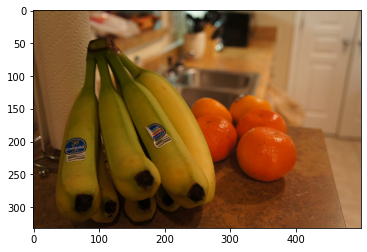

In [17]:
img = './data/VisualGenome/VG_100K/2380101.jpg'
im = cv2.imread(img)
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

In [23]:
folder = './data/VisualGenome/annotation/regionfiles/'
files = os.listdir(folder)

for file in files:
    if file == '2380101.json':
        test_img = json.load(open(folder+file), encoding='utf-8')

In [24]:
test_img

{'1512208': {'objects': [{'object_id': 1350568,
    'name': 'orange',
    'attributes': ['five'],
    'x': 246,
    'y': 158,
    'w': 66,
    'h': 76},
   {'object_id': 1350569,
    'name': 'counter',
    'attributes': [],
    'x': 0,
    'y': 173,
    'w': 477,
    'h': 159},
   {'object_id': 1350570,
    'name': 'banana',
    'attributes': [],
    'x': 105,
    'y': 58,
    'w': 165,
    'h': 236}],
  'relationships': [{'relationship_id': 3607942,
    'name': 'on',
    'subject_id': 1350568,
    'object_id': 1350569},
   {'relationship_id': 'sentSG',
    'name': 'beside',
    'subject_id': 1350569,
    'object_id': 1350570}],
  'region_id': 1512208,
  'width': 157,
  'height': 131,
  'image_id': 2380101,
  'phrase': 'five oranges on the counter beside bananas',
  'y': 131,
  'x': 245},
 '1512210': {'objects': [{'object_id': 1350571,
    'name': 'towel',
    'attributes': ['white', 'paper'],
    'x': 0,
    'y': 0,
    'w': 92,
    'h': 218},
   {'object_id': 1350586,
    'name': 'ho